In [1]:
from astropy.table import Table

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# Data

In [28]:
data_filename = '../spirals/Pipe3D-master_file_vflag_BB_minimize_chi10_smooth2p27_mapFit_N2O2_HIdr2_noWords_v2.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [3]:
kias_filename = '/Users/kellydouglass/Documents/Research/data/kias1033_5_MPAJHU_ZdustOS_HI100_NSAv012_CMDJan2020.txt'

kias = Table.read(kias_filename, format='ascii.commented_header')

In [41]:
bad_boolean = np.logical_or(data['M90_map'] == -99, data['M90_disk_map'] == -99)

good_galaxies = data[~bad_boolean]

print(len(good_galaxies))

3061


In [40]:
HI_boolean = np.logical_or(good_galaxies['logHI'] == -99, good_galaxies['logHI'] == -999)

goodHI_galaxies = good_galaxies[~HI_boolean]

print(len(goodHI_galaxies))

1352


### Calculate mass ratios

In [58]:
good_galaxies['M90_Mdisk_ratio'] = 10**(good_galaxies['M90_map'] - good_galaxies['M90_disk_map'])
goodHI_galaxies['M90_Mdisk_ratio'] = 10**(goodHI_galaxies['M90_map'] - goodHI_galaxies['M90_disk_map'])

goodHI_galaxies['M90_MdiskHI_ratio'] = 10**goodHI_galaxies['M90_map']/(10**goodHI_galaxies['M90_disk_map'] + 10**goodHI_galaxies['logHI'])

In [59]:
BC_boolean = good_galaxies['CMD_class'] == 1
GV_boolean = good_galaxies['CMD_class'] == 2
RS_boolean = good_galaxies['CMD_class'] == 3

BC = good_galaxies[BC_boolean]
GV = good_galaxies[GV_boolean]
RS = good_galaxies[RS_boolean]

In [60]:
BC_HI_boolean = goodHI_galaxies['CMD_class'] == 1
GV_HI_boolean = goodHI_galaxies['CMD_class'] == 2
RS_HI_boolean = goodHI_galaxies['CMD_class'] == 3

BC_HI = goodHI_galaxies[BC_HI_boolean]
GV_HI = goodHI_galaxies[GV_HI_boolean]
RS_HI = goodHI_galaxies[RS_HI_boolean]

In [34]:
kias_BC_boolean = kias['CMD_class'] == 1
kias_GV_boolean = kias['CMD_class'] == 2
kias_RS_boolean = kias['CMD_class'] == 3

kias_BC = kias[kias_BC_boolean]
kias_GV = kias[kias_GV_boolean]
kias_RS = kias[kias_RS_boolean]

# Relationship between $M_*$ and $M_\text{tot}$

In [45]:
def bin_median(data, bin_quantity, bins, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin_quantity : string
        Name of column in data by which to bin the data
        
    bins : ndarray of shape (n,)
        Array of bin edges
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Median values of median_quantity for each bin of bin_quantity
        
    binned_err : ndarray of shape (n,)
        Statistical uncertainty in each bin (1/sqrt(N), where N is the number of 
        objects in the bin)
    '''
    
    if bin_quantity in ['Mstar', 'NSA_Mstar', 'Mstar_NSA']:
        bin_indices = np.digitize(np.log10(data[bin_quantity]), bins)
    else:
        bin_indices = np.digitize(data[bin_quantity], bins)
    
    n_bins = len(bins)
    
    binned_median = np.zeros(n_bins)
    binned_err = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find galaxies in this bin
        gal_in_bin = bin_indices == i
        
        # Calculate median of galaxies in bin
        if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot', 'Mstar_NSA']:
            binned_median[i] = np.log10(np.nanmedian(data[median_quantity][gal_in_bin]))
        elif median_quantity in ['M90_map', 'logHI']:
            binned_median[i] = np.log10(np.nanmedian(10**data[median_quantity][gal_in_bin]))
        else:
            binned_median[i] = np.nanmedian(data[median_quantity][gal_in_bin])
        
        # Calculate statistical uncertainty in bin
        binned_err[i] = 1/np.sqrt(sum(gal_in_bin))
        
    return binned_median, binned_err

In [46]:
Mdisk_bins = np.linspace(8.5,12,9)
Mdisk_bin_width = Mdisk_bins[1] - Mdisk_bins[0]

BC_M90_medians, BC_M90_errs = bin_median(BC, 'M90_disk_map', Mdisk_bins, 'M90_map')
GV_M90_medians, GV_M90_errs = bin_median(GV, 'M90_disk_map', Mdisk_bins, 'M90_map')
RS_M90_medians, RS_M90_errs = bin_median(RS, 'M90_disk_map', Mdisk_bins, 'M90_map')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-45-c68f859239fb>:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


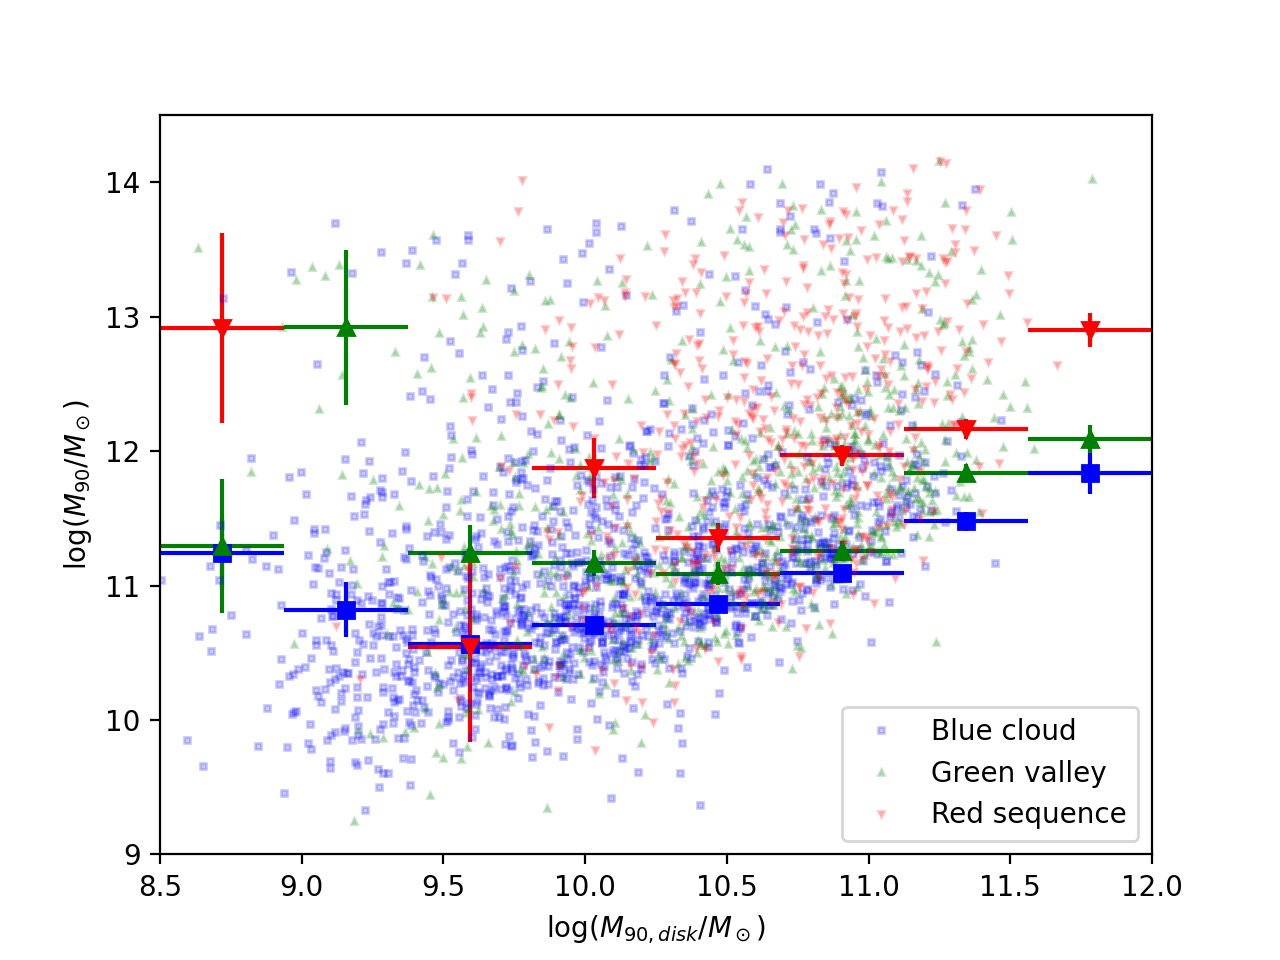

In [47]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.plot(BC['M90_disk_map'], BC['M90_map'], 'bs', markersize=2, alpha=0.2, label='Blue cloud')
plt.plot(GV['M90_disk_map'], GV['M90_map'], 'g^', markersize=2, alpha=0.2, label='Green valley')
plt.plot(RS['M90_disk_map'], RS['M90_map'], 'rv', markersize=2, alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_M90_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_M90_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_M90_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{90}/M_\odot$)')

plt.xlim([8.5,12])
plt.ylim([9,14.5])

plt.legend();
################################################################################

# Relationship between $M_*$ and $M_{HI}$

In [48]:
BC_HI_medians, BC_HI_errs = bin_median(BC_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
GV_HI_medians, GV_HI_errs = bin_median(GV_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
RS_HI_medians, RS_HI_errs = bin_median(RS_HI, 'M90_disk_map', Mdisk_bins, 'logHI')

kias_BC_NSA_HI_medians, kias_BC_NSA_HI_errs = bin_median(kias_BC, 'Mstar_NSA', Mdisk_bins, 'HImass')
kias_GV_NSA_HI_medians, kias_GV_NSA_HI_errs = bin_median(kias_GV, 'Mstar_NSA', Mdisk_bins, 'HImass')
kias_RS_NSA_HI_medians, kias_RS_NSA_HI_errs = bin_median(kias_RS, 'Mstar_NSA', Mdisk_bins, 'HImass')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-45-c68f859239fb>:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<IPython.core.display.Javascript object>


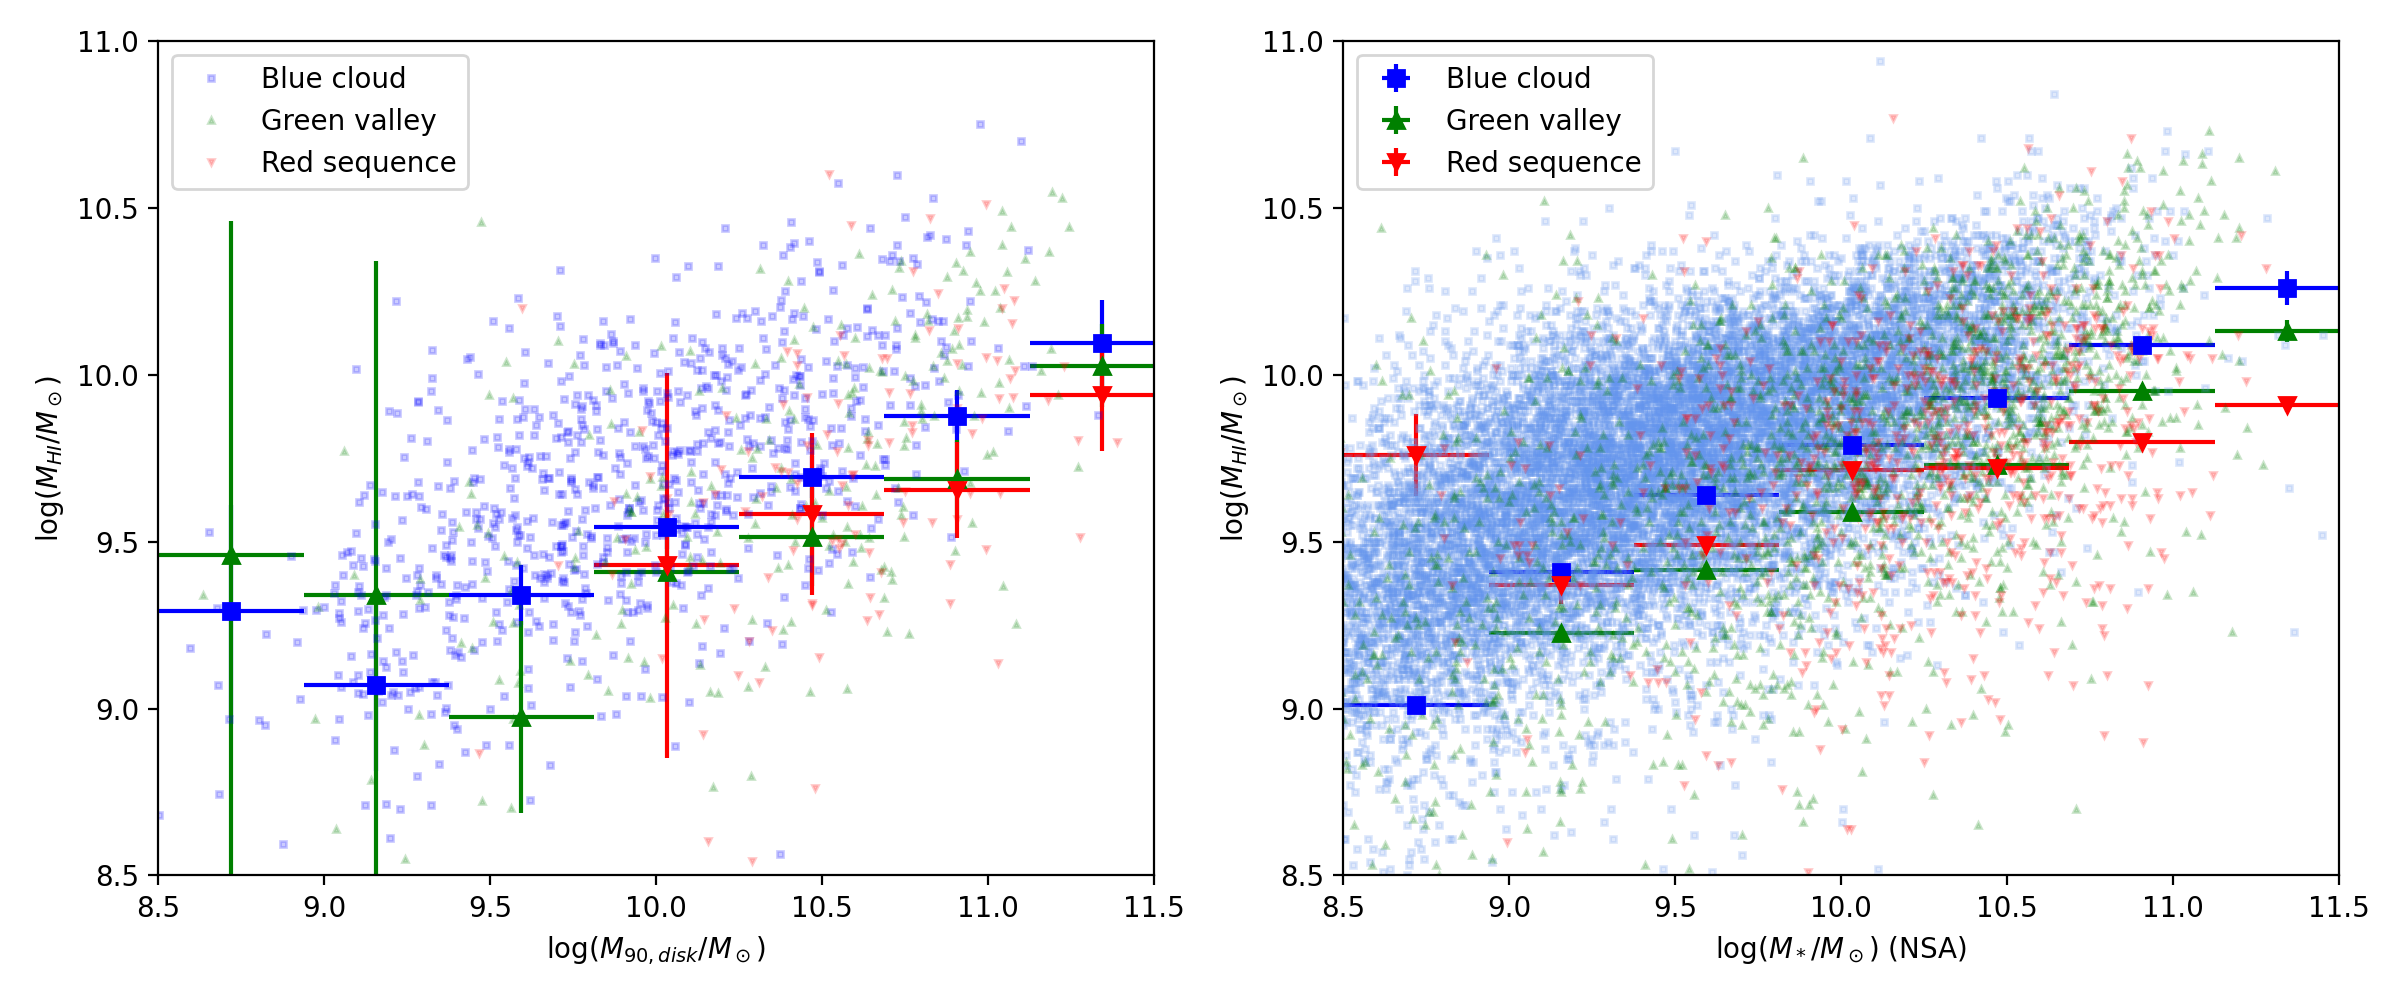

In [49]:
plt.figure(figsize=(12,5))

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.subplot(121)
plt.plot(BC_HI['M90_disk_map'], BC_HI['logHI'], 'bs', markersize=2, 
         alpha=0.2, label='Blue cloud')
plt.plot(GV_HI['M90_disk_map'], GV_HI['logHI'], 'g^', markersize=2, 
         alpha=0.2, label='Green valley')
plt.plot(RS_HI['M90_disk_map'], RS_HI['logHI'], 'rv', markersize=2, 
         alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_HI_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_HI_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_HI_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8.5,11.5])
plt.ylim([8.5,11])

plt.legend()
################################################################################


################################################################################
# SDSS DR7
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(np.log10(kias_BC['Mstar_NSA']), kias_BC['HImass'], 's', 
         color='CornflowerBlue', markersize=2, alpha=0.2)
plt.plot(np.log10(kias_GV['Mstar_NSA']), kias_GV['HImass'], 'g^', markersize=2, 
         alpha=0.2)
plt.plot(np.log10(kias_RS['Mstar_NSA']), kias_RS['HImass'], 'rv', markersize=2, 
         alpha=0.2)

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_BC_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_BC_NSA_HI_errs, 
             c='b', fmt='s', label='Blue cloud')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_GV_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_GV_NSA_HI_errs, 
             c='g', fmt='^', label='Green valley')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_RS_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_RS_NSA_HI_errs, 
             c='r', fmt='v', label='Red sequence')

plt.xlabel('log($M_*/M_\odot$) (NSA)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8.5,11.5])
plt.ylim([8.5,11])

plt.legend()
################################################################################

plt.tight_layout();

# Distribution in mass ratios

In [50]:
def hist_norm(data, bins):
    '''
    Return the values to plot a normalized histogram.
    
    
    PARAMETERS
    ==========
    
    data : column of astropy table
        Data to be binned
        
    bins : ndarray of shape (n,)
        Bin edges
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Number of objects in each bin, normalized by the total number of 
        objects in the sample
        
    binned_data_err : ndarray of shape (n,)
        Statistical uncertainty in the count in each bin.
    '''
    
    # Bin data
    counts,_ = np.histogram(data, bins=bins)
    
    # Normalize binned data
    binned_data = counts/len(data)
    
    # Calculate uncertainty in each bin
    binned_data_err = 1/(np.sqrt(counts)*len(data))
    
    return binned_data, binned_data_err

In [51]:
mass_bins = np.linspace(0,25,101)
mass_bin_width = mass_bins[1] - mass_bins[0]

BC_M90Mdisk_binned, BC_M90Mdisk_err = hist_norm(BC['M90_Mdisk_ratio'], bins=mass_bins)
GV_M90Mdisk_binned, GV_M90Mdisk_err = hist_norm(GV['M90_Mdisk_ratio'], bins=mass_bins)
RS_M90Mdisk_binned, RS_M90Mdisk_err = hist_norm(RS['M90_Mdisk_ratio'], bins=mass_bins)

<ipython-input-50-0fefddb2a605>:34: RuntimeWarning: divide by zero encountered in true_divide
  binned_data_err = 1/(np.sqrt(counts)*len(data))


### $M_{90}/M_{90, \text{disk}}$

<IPython.core.display.Javascript object>


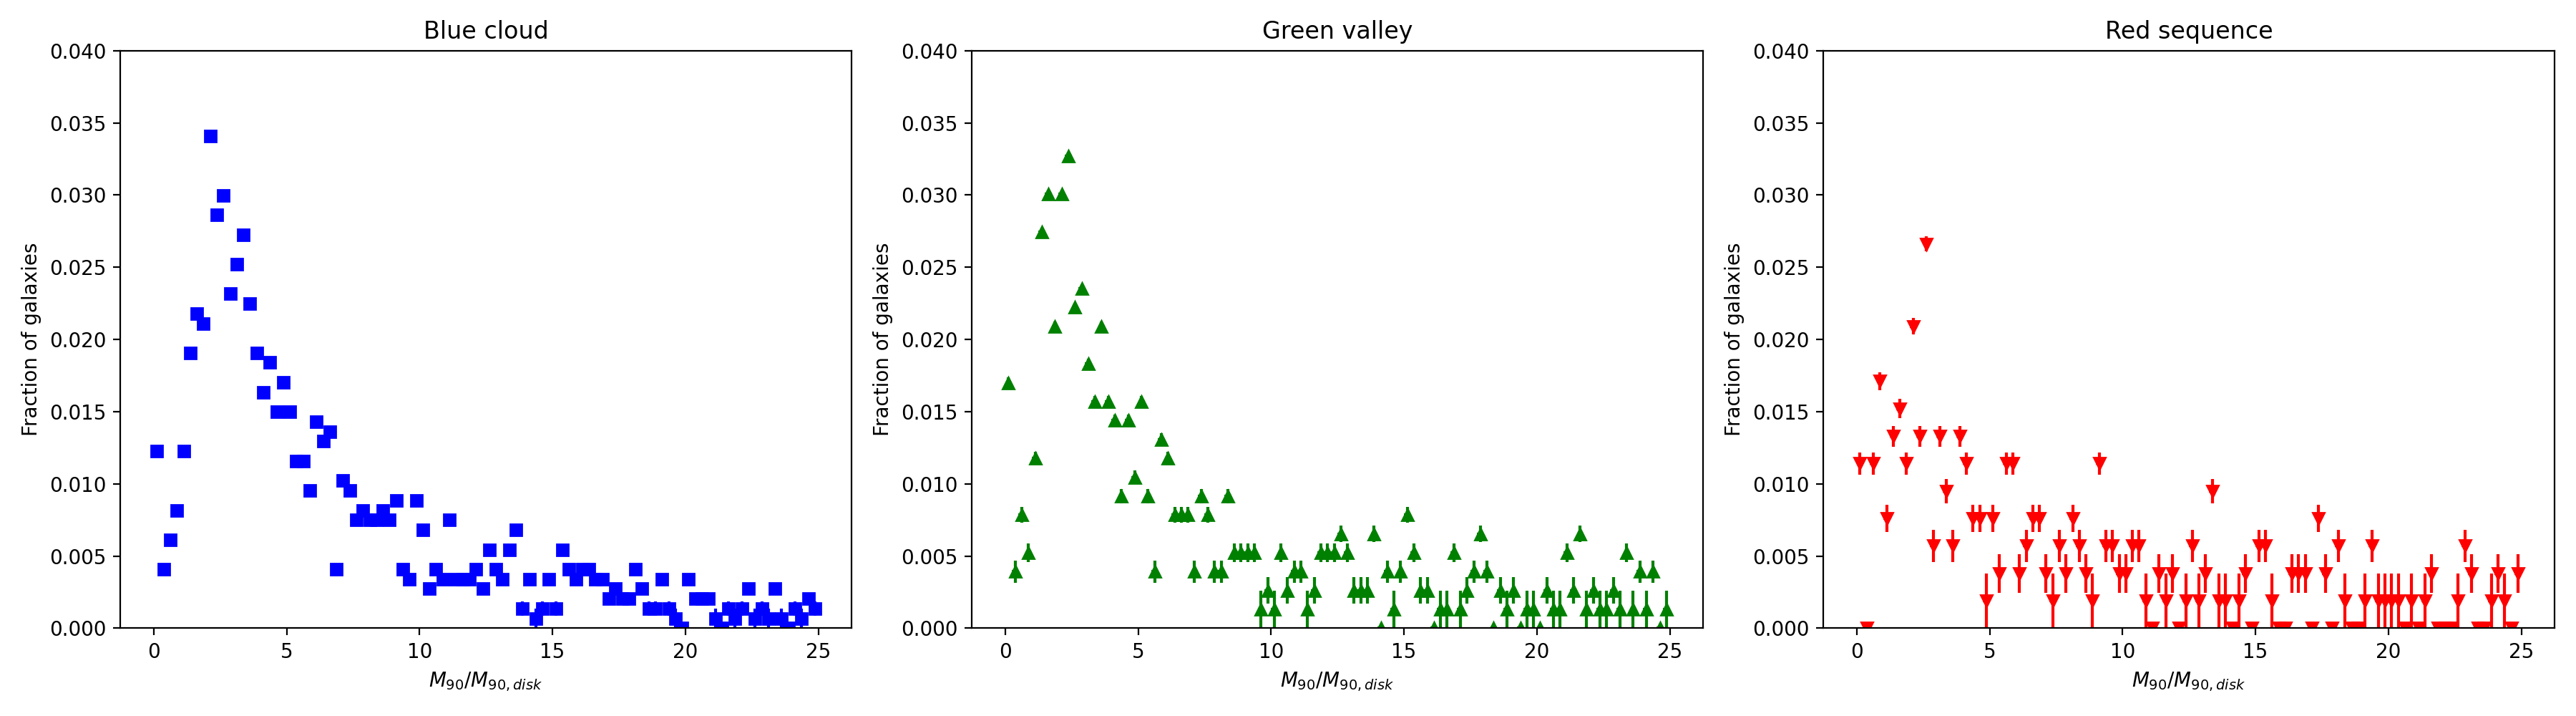

In [53]:
plt.figure(figsize=(18,5))

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mdisk_err, fmt='bs')

plt.ylim(0,0.04)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mdisk_err, fmt='g^')

plt.ylim(0,0.04)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mdisk_err, fmt='rv')

plt.ylim(0,0.04)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

### $M_{90}/(M_{90, \text{disk}} + M_\text{HI})$

In [54]:
BC_M90Mvis_binned, BC_M90Mvis_err = hist_norm(BC_HI['M90_MdiskHI_ratio'], bins=mass_bins)
GV_M90Mvis_binned, GV_M90Mvis_err = hist_norm(GV_HI['M90_MdiskHI_ratio'], bins=mass_bins)
RS_M90Mvis_binned, RS_M90Mvis_err = hist_norm(RS_HI['M90_MdiskHI_ratio'], bins=mass_bins)

<ipython-input-50-0fefddb2a605>:34: RuntimeWarning: divide by zero encountered in true_divide
  binned_data_err = 1/(np.sqrt(counts)*len(data))


<IPython.core.display.Javascript object>


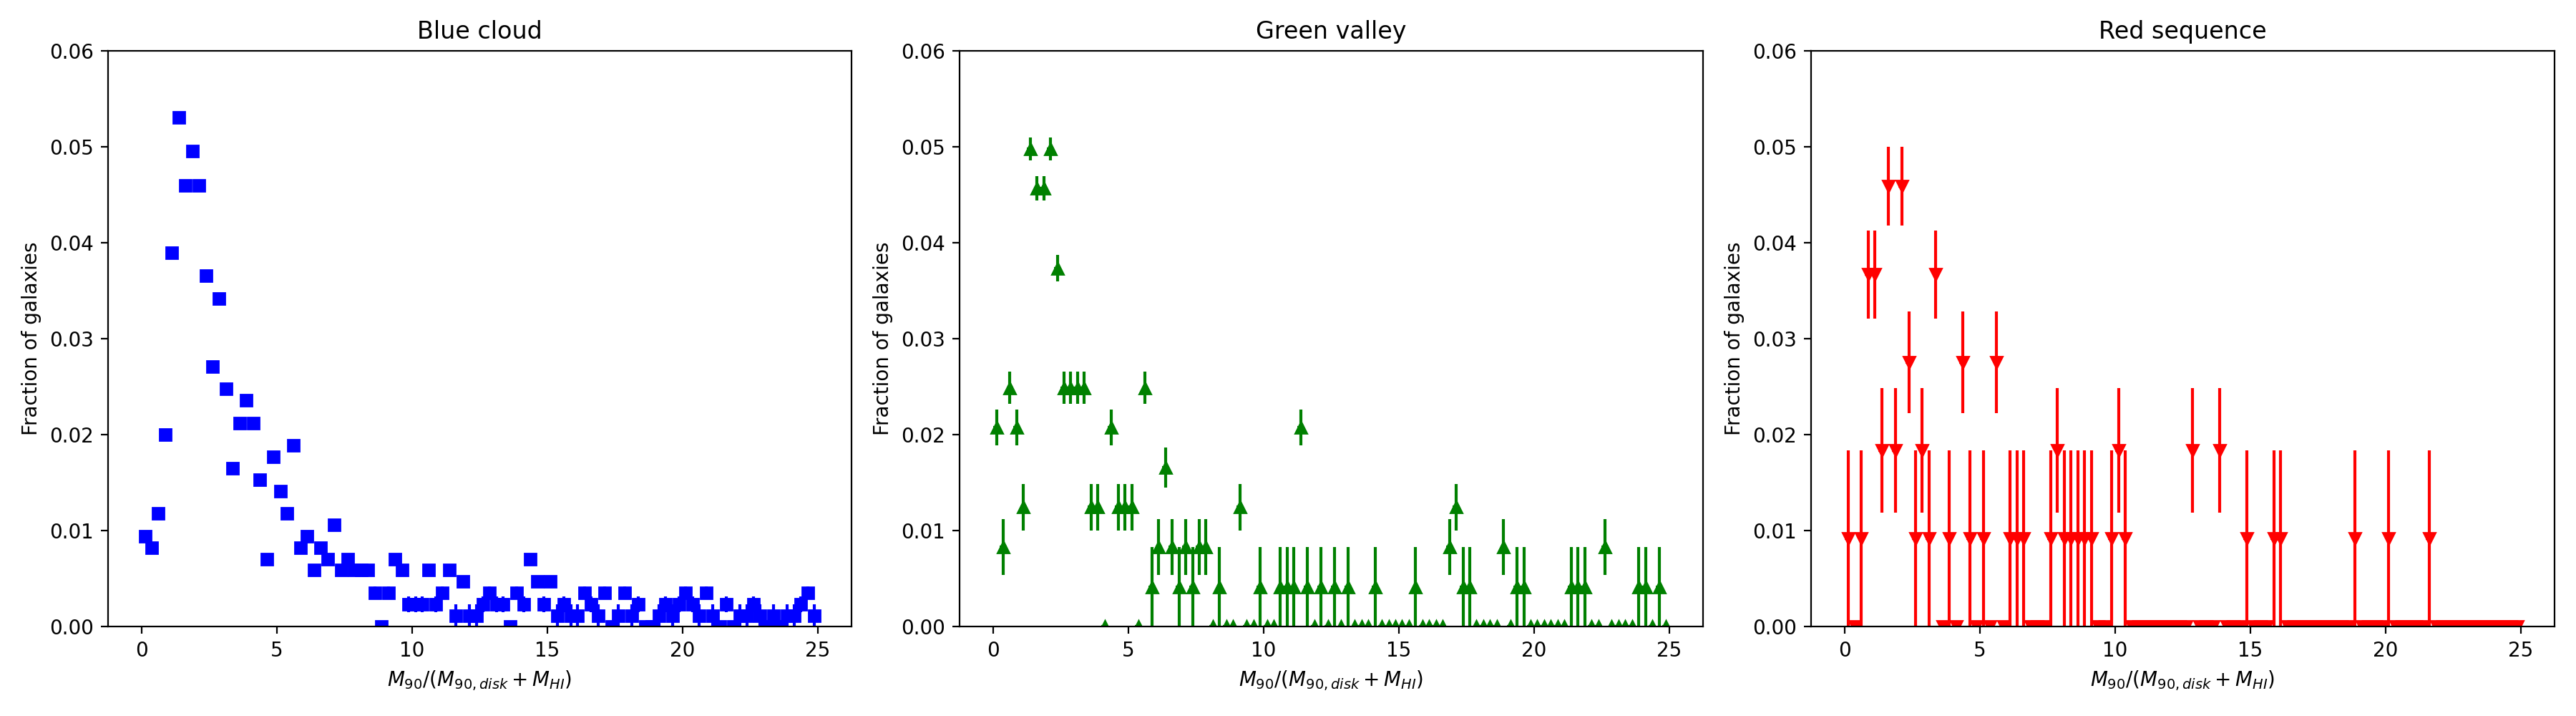

In [56]:
plt.figure(figsize=(18,5))

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mvis_err, fmt='bs')

plt.ylim(0,0.06)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mvis_err, fmt='g^')

plt.ylim(0,0.06)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mvis_err, fmt='rv')

plt.ylim(0,0.06)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

# Relationship between $M_r$ and the mass ratios

In [61]:
Mr_bins = np.linspace(-22.5, -17.5, 13)
Mr_bin_width = Mr_bins[1] - Mr_bins[0]

Mdisk_medians, Mdisk_errs = bin_median(good_galaxies, 'rabsmag', Mr_bins, 'M90_Mdisk_ratio')
MdiskHI_medians, MdiskHI_errs = bin_median(goodHI_galaxies, 'rabsmag', Mr_bins, 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-45-c68f859239fb>:58: RuntimeWarning: divide by zero encountered in double_scalars
  binned_err[i] = 1/np.sqrt(sum(gal_in_bin))


<IPython.core.display.Javascript object>


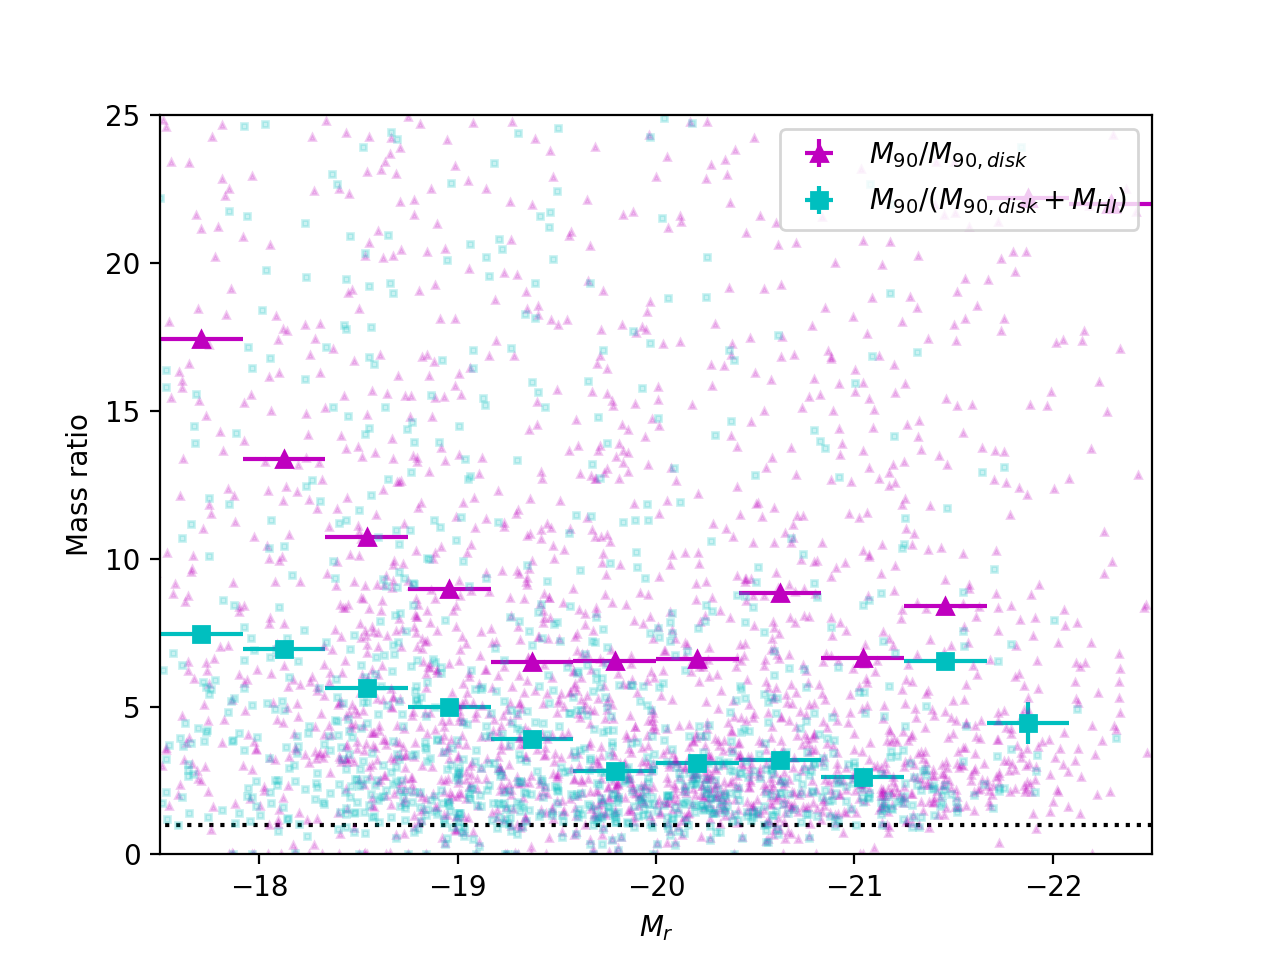

In [62]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, -22.5, -17.5, colors='k', linestyle=':')

plt.plot(good_galaxies['rabsmag'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['rabsmag'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Mr_bins + 0.5*Mr_bin_width, Mdisk_medians, 
             xerr=0.5*Mr_bin_width, yerr=Mdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Mr_bins + 0.5*Mr_bin_width, MdiskHI_medians, 
             xerr=0.5*Mr_bin_width, yerr=MdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$M_r$')
plt.ylabel('Mass ratio')

plt.xlim([-17.5,-22.5])
plt.ylim([0,25])

plt.legend();
################################################################################

# Relationship between metallicity and mass ratios

In [63]:
Z_bins = np.linspace(8.5, 10.5, 13)
Z_bin_width = Z_bins[1] - Z_bins[0]

ZMdisk_medians, ZMdisk_errs = bin_median(good_galaxies, 'Z12logOH', Z_bins, 'M90_Mdisk_ratio')
ZMdiskHI_medians, ZMdiskHI_errs = bin_median(goodHI_galaxies, 'Z12logOH', Z_bins, 'M90_MdiskHI_ratio')

<IPython.core.display.Javascript object>


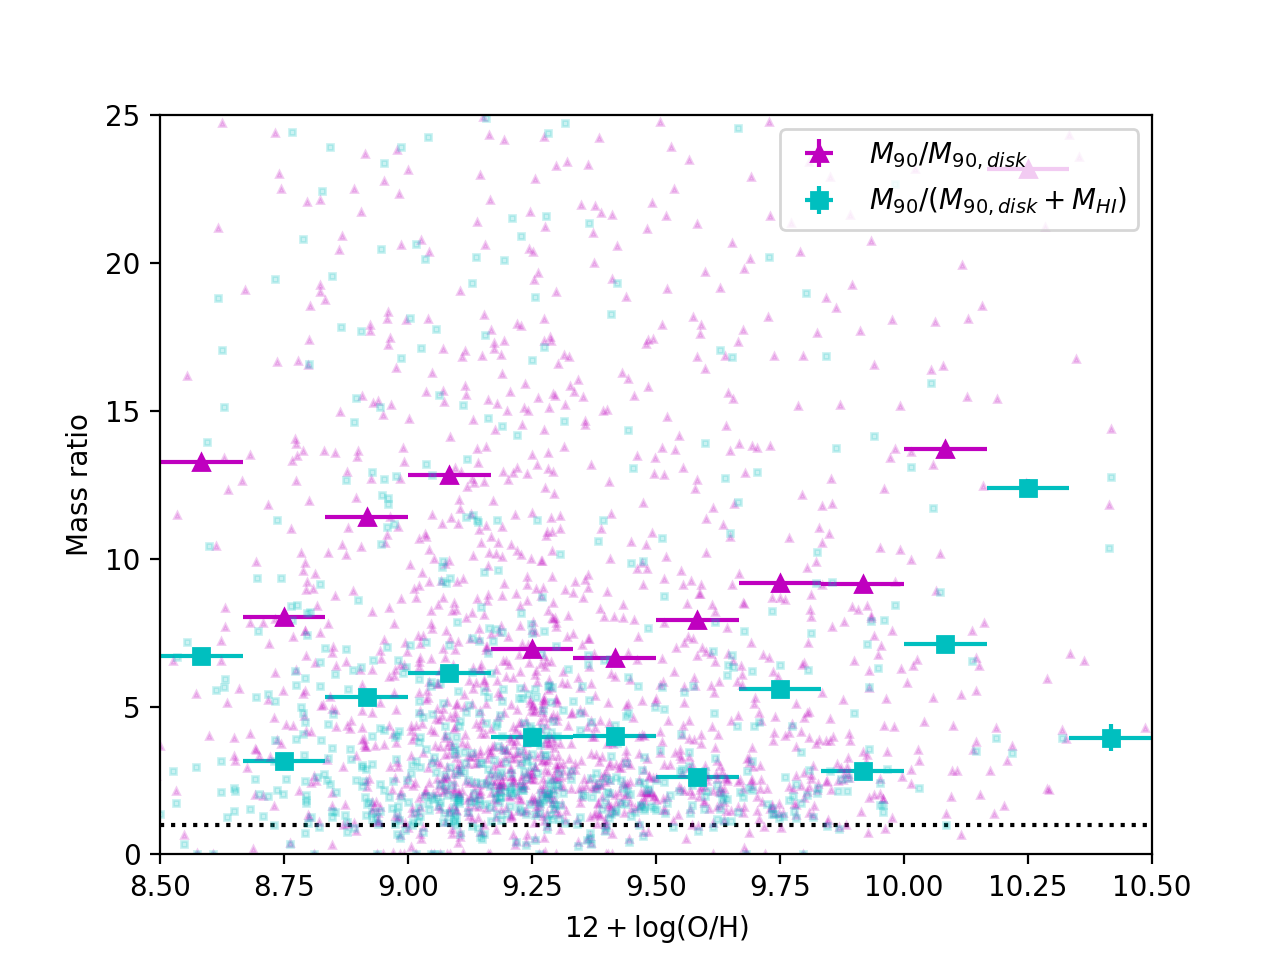

In [64]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, 8.5, 10.5, colors='k', linestyle=':')

plt.plot(good_galaxies['Z12logOH'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['Z12logOH'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdisk_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdiskHI_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$12 + \log$(O/H)')
plt.ylabel('Mass ratio')

plt.xlim([8.5,10.5])
plt.ylim([0,25])

plt.legend();
################################################################################

# Relationship between $M_r$, metallicity, and mass ratio

In [65]:
def bin2D_median(data, bin1_quantity, bin2_quantity, bins1, bins2, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity1 and bin_quantity2.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin1_quantity, bin2_quantity : string
        Name of columns in data by which to bin the data
        
    bins1, bins2 : ndarray of shape (n,)
        Arrays of bin edges (arrays do not need to be the same length)
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,m)
        Median values of median_quantity for each bin of bin1_quantity and bin2_quantity
    '''
    
    if bin1_quantity in ['Mstar', 'NSA_Mstar']:
        bin1_indices = np.digitize(np.log10(data[bin1_quantity]), bins1)
    else:
        bin1_indices = np.digitize(data[bin1_quantity], bins1)
    
    if bin2_quantity in ['Mstar', 'NSA_Mstar']:
        bin2_indices = np.digitize(np.log10(data[bin2_quantity]), bins2)
    else:
        bin2_indices = np.digitize(data[bin2_quantity], bins2)
    
    n1_bins = len(bins1)
    n2_bins = len(bins2)
    
    binned_median = np.zeros((n1_bins, n2_bins))
    
    for i in range(n1_bins):
        for j in range(n2_bins):
            # Find galaxies in this bin
            gal_in_bin = np.logical_and(bin1_indices == i, bin2_indices == j)

            # Calculate median of galaxies in bin
            if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot']:
                binned_median[i,j] = np.log10(np.median(data[median_quantity][gal_in_bin]))
            else:
                binned_median[i,j] = np.median(data[median_quantity][gal_in_bin])
        
    return binned_median

In [66]:
Mr_bins2d = np.linspace(-22.5, -17.5, 5)
Z_bins2d = np.linspace(8.5, 10.5, 5)

M90Mdisk_median = bin2D_median(good_galaxies, 
                               'rabsmag', 'Z12logOH', 
                               Mr_bins2d, Z_bins2d, 
                               'M90_Mdisk_ratio')

M90MHI_median = bin2D_median(goodHI_galaxies, 
                             'rabsmag', 'Z12logOH', 
                             Mr_bins2d, Z_bins2d, 
                             'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3370: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


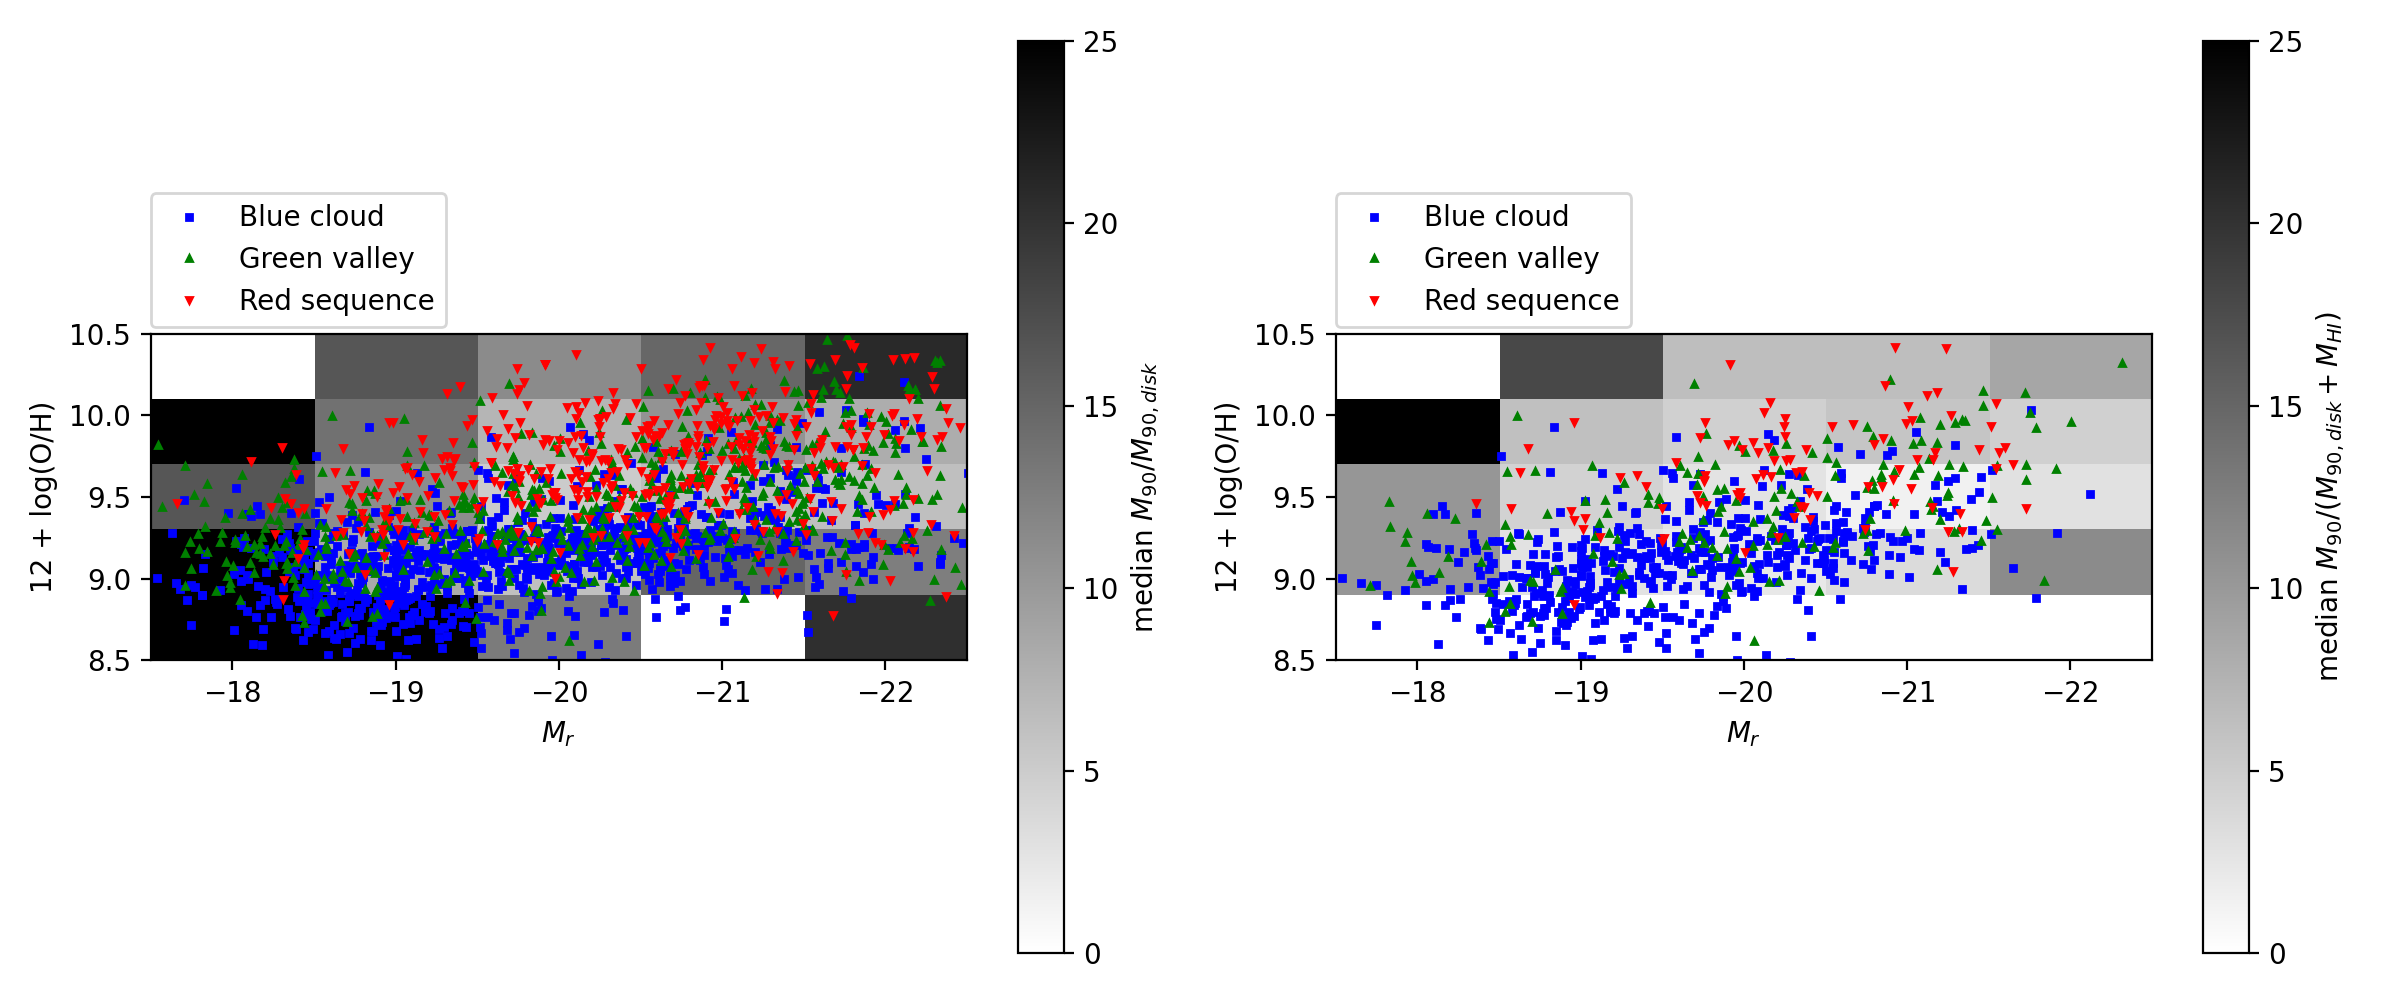

In [67]:
plt.figure(figsize=(12,5))

################################################################################
# Mtot/M* with MaNGA stellar mass
#-------------------------------------------------------------------------------
plt.subplot(121)

plt.imshow(M90Mdisk_median, cmap='gray_r', vmin=0, vmax=25,
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC['rabsmag'], BC['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV['rabsmag'], GV['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS['rabsmag'], RS['Z12logOH'], 'rv', markersize=2, label='Red sequence')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) with MaNGA stellar mass
#-------------------------------------------------------------------------------
plt.subplot(122)

plt.imshow(M90MHI_median, cmap='gray_r', vmin=0, vmax=25,
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC_HI['rabsmag'], BC_HI['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV_HI['rabsmag'], GV_HI['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS_HI['rabsmag'], RS_HI['Z12logOH'], 'rv', markersize=2, label='Red sequence')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

In [68]:
good_galaxies

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,M90_Mdisk_ratio
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
10001,12704,483,456,51924,59044,133.98996686918764,57.677967666915094,0.15000000596046448,81.21926879882812,0.014121513813734055,4286639360.0,2.0,131.01025240011285,19.676026158251116,2.8987493963655893,0.9320010517634041,10.561579728586807,167.36819730056942,55.37941486751162,1.5603496124473835,0.7384203259825936,47.04399759256833,114.38748951090233,2.066567760147777,11.186389689559748,5.360847852417152,33.66362235935509,0.04750613123178482,0.00122847675844281,13105279432.977133,3936483090.9370747,5510141659.441766,3936483090.9370747,7595137773.535367,0.7254827790802428,0.5182898860180557,-18.730289459228516,2.373751698007841,0.442445748488078,2.7436231797149664,0.8109164906414781,2.2338502327998295,0.0792251267877304,-99.0,-99.0,-99.0,0,0,0.8124292098912929,3.6187690455821793,2.5895094122580837,-1,-99.0,2.1984682977199554,0.2559453032104637,3.2839520528476394,1.7254827790802427,0.5182898860180557,1.4387059747053537,120.31707348143723,117.87988927383222,-6.000375169033698,0.28730629601302937,0.998627039450544,83.52335485491763,1.4386276080692604,-5.667678803696452,3.4110746095158273,37.52377413840347,0.5439952893079695,39.040222659700916,0.8436706578159239,251.989311872076,237.5102739154953,0.9272576875301647,0.858736376179446,2.9950696581613543,1.531228622882399,11.002047694545139,11.277377970161712,1226.8826834368272,42.21839027025036,1.0806885517253293,0.023583319463693266,9.95438400669585,11.847215121786643,0.8818602095452142,33.156402587890625,15.738173257258106,35941367.32412297,9.239542007446289,298.85899314722644,295.95398745139903,-1,11.159986978070679
8466,12705,1366,333,53063,272117,171.30192456278215,45.06676854548666,0.3019966185092926,7.65966796875,0.04525795951485634,7202819584.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.05786323547363281,0.00296707739920057,-1.0,-1.0,-1.0,-1.0,113263292.07990375,-1.0,-1.0,-19.424922943115234,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-99.0,-99.0,1.0,-99,1,-1.0,-1.0,-1.0,1250933,9.076134089126212,1.7628148198127747,0.5566917293233082,0.6577949565858545,-1.0,-1.0,1.333640524296133,0.35126261983